# MaterialsCoord benchmarking – timing analysis

Calculate the time taken to perform the MaterialsCoord benchmark and use the scores to plot a Pareto front.

*Written using:*
- MaterialsCoord==0.1.0

*Authors: Alex Ganose (10/12/19)*

First, lets initialize the near neighbor methods we are interested in.

In [1]:
from pymatgen.analysis.local_env import BrunnerNN_reciprocal, EconNN, JmolNN, \
                                        MinimumDistanceNN, MinimumOKeeffeNN, MinimumVIRENN, \
                                        VoronoiNN, CrystalNN

nn_methods = [
    BrunnerNN_reciprocal(), EconNN(), JmolNN(), CrystalNN(), VoronoiNN(tol=0.5),
    MinimumDistanceNN(), MinimumOKeeffeNN(), MinimumVIRENN()
]

Next, import the benchmark and choose which structures we are interested in.

In [2]:
from materialscoord.core import Benchmark

structure_groups = ["common_binaries", "elemental", "A2BX4", "ABX3", "ABX4"]

bm = Benchmark.from_structure_group(structure_groups)

Calculate the timings for each algorithm. Set `return_dataframe` to `False` so that no time is spent putting the DataFrame into Pandas.

In [3]:
import time

timings = []
for nn_method in nn_methods:
    t0 = time.perf_counter()
    bm.benchmark([nn_method], return_dataframe=False)
    timings.append(time.perf_counter() - t0)

/Users/alexganose/dev/src/pymatgen/pymatgen/analysis/local_env.py:3532: UserWarning: CrystalNN: distance cutoffs set but no oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn("CrystalNN: distance cutoffs set but no oxidation "
/Users/alexganose/dev/src/pymatgen/pymatgen/analysis/local_env.py:3347: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  "CrystalNN: cannot locate an appropriate radius, "


Calculate the benchmark scores for each algorithm.

In [15]:
df = bm.score(nn_methods, site_type="cation")
scores = df.loc["Total"].values

Define a function to calculate the Pareto front.

In [16]:
def pareto_frontier(x, y, maximize_x=False, maximize_y=False):    
    sort = sorted([[x[i], y[i]] for i in range(len(x))], reverse=maximize_x)
    
    # Start the Pareto frontier with the first value in the sorted list
    p_front = [sort[0]]
    
    # Loop through the sorted list
    for pair in sort[1:]:
        if maximize_y: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
                
    # Turn resulting pairs back into a list of Xs and Ys
    p_front_x = [pair[0] for pair in p_front]
    p_front_y = [pair[1] for pair in p_front]
    return p_front_x, p_front_y

Finally, plot the results.

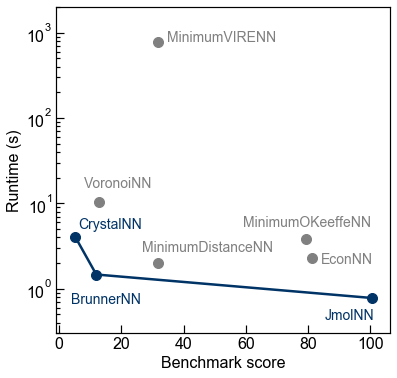

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

p_front = pareto_frontier(scores, timings)

# define matplotlib style settings
style = {
    "font.sans-serif": ["Helvetica", "Arial"], "axes.labelsize": 16,
    "xtick.labelsize": 16, "ytick.labelsize": 16, "xtick.direction": "in",
    "ytick.direction": "in", "xtick.major.size": 8, "xtick.minor.size": 4,
    "ytick.major.size": 8, "ytick.minor.size": 4, "lines.linewidth": 2.5,
    "lines.markersize": 10, "axes.linewidth": 1.2, "xtick.major.width": 1.2,
    "xtick.minor.width": 1.2, "ytick.major.width": 1.2, "ytick.minor.width": 1.2,  
}

# use these shifts to fine tune the positions of the labels
shifts = {
    "BrunnerNN_reciprocal": {"x": -8, "y": -0.8}, 
    "EconNN": {"x": 3, "y": -0.3},
    "JmolNN": {"x": -15, "y": -0.35},
    "CrystalNN": {"x": 1, "y": 1},
    "VoronoiNN": {"x": -5, "y": 5},
    "MinimumDistanceNN": {"x": -5, "y": 0.7},
    "MinimumOKeeffeNN": {"x": -20, "y": 1.5},
    "MinimumVIRENN": {"x": 3, "y": 10},
}

highlight = "#003366"

plt.style.use(style)
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
nn_method_mapping = {"BrunnerNN_reciprocal": "BrunnerNN"}


for nn_method, (x, y) in zip(nn_methods, zip(scores, timings)):
    algo = nn_method.__class__.__name__
    
    xshift = shifts[algo]["x"]
    yshift = shifts[algo]["y"]
    
    algo = nn_method_mapping.get(algo, algo)
    
    # color the points depending on whether 
    on_front = x in p_front[0] and y in p_front[1]
    color = highlight if on_front else "gray" 
    
    ax.scatter(x, y, c=color)
    plt.text(x + xshift, y + yshift, algo, fontsize=14, color=color)

# plot the Pareto front line
ax.plot(p_front[0], p_front[1], zorder=-1, color=highlight)

ax.set_ylim((0.3, 2e3))
ax.set(xlabel="Benchmark score", ylabel="Runtime (s)")
ax.semilogy()

plt.savefig(os.path.join("plots", "timing.pdf"),
            dpi=400, bbox_inches="tight")
plt.show()